# Light curve modeling

```{admonition} Talk
:class: tip
Introduction to *JAX* and *jaxoplanet*
```

Finally, we may want to model the light curve of our transit, in order to get an idea about the properties of the system.

Let's first load the data and plot it.

/Users/lgarcia/mambaforge/envs/pysnack10/lib/python3.11/site-packages/prose/console_utils.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


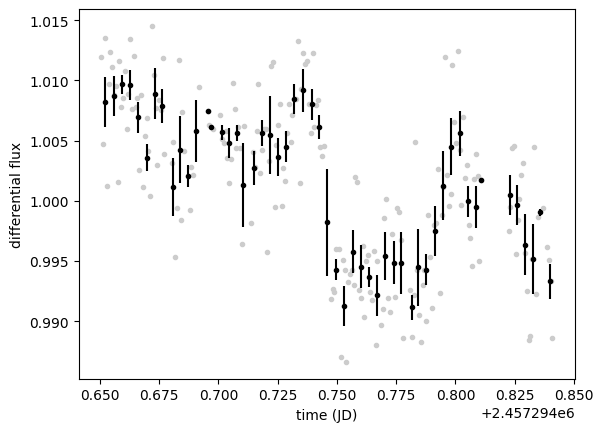

In [1]:
from prose import Fluxes
import matplotlib.pyplot as plt

# this is the second dataset
data = Fluxes.load("../data/TRAPPIST-South_20150928_UCDTS-48_I+z.flux")

mask = data.time > 2457294.65
data = data.mask(mask)

time = data.time
flux = data.flux

ax = plt.subplot(xlabel="time (JD)", ylabel="differential flux")
data.plot()
data.bin(5 / 60 / 24, estimate_error=True).errorbar()

As we will model systematics in a linear way, let's redefine our design matrix

In [12]:
import numpy as np

X = np.vstack(
    [
        data.data["airmass"],
        data.data["fwhm"],
        data.data["bkg"],
        data.data["dx"],
        data.data["dy"],
    ]
)

# normalizing
X = (X - np.mean(X, axis=1)[:, None]) / np.std(X, axis=1)[:, None]

# adding a constant baseline
X = np.vstack([X, np.ones(X.shape[1])])

Next, we will use [jaxoplanet](https://jax.exoplanet.codes/en/latest/) to define the transit model

In [13]:
import jax

jax.config.update("jax_enable_x64", True)

from numpyro import distributions, deterministic, sample
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit
import numpyro_ext
import jax.numpy as jnp
from astropy import units as u


def transit_model(time, params):
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )

    flux = limb_dark_light_curve(orbit, jnp.array([0.65, 0.28]))(time)
    return flux


def light_curve_model(time, params):
    flux = transit_model(time, params)
    systematics = jnp.dot(X.T, params["w"])
    return flux + systematics

Here is the model of the light curve with some initial parameters we guessed by hand

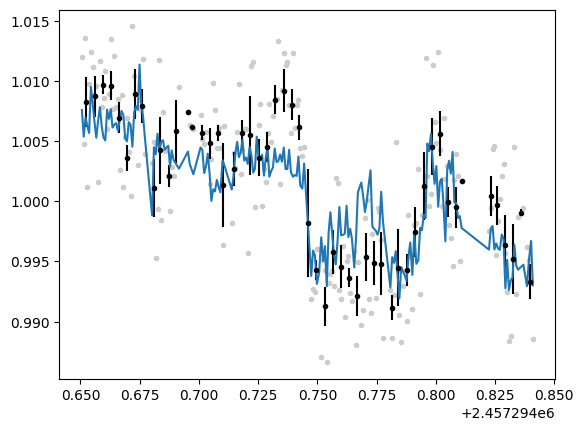

In [15]:
import numpy as np

prior = {
    "t0": 2457294.7676798534,
    "duration": 0.04,
    "b": 0.0,
    "r": 0.05,
    "period": 10.0,
    "w": jnp.linalg.lstsq(X.T, flux, rcond=None)[0],
    "error": jnp.median(data.error),
}

modeled_lc = light_curve_model(time, prior)

data.plot()
data.bin(5 / 60 / 24, estimate_error=True).errorbar()
plt.plot(time, modeled_lc, label="modeled light curve")

## Maximum likelihood estimation

Let's find the maximum likelihood model using [jaxopt](https://jaxopt.github.io/stable/index.html)

In [19]:
import jaxopt


def nll(params):
    modeled_lc = light_curve_model(time, params)
    return 0.5 * jnp.sum((flux - modeled_lc) ** 2 / data.error**2)


solver = jaxopt.ScipyMinimize(fun=nll)
opt = solver.run(prior).params

And plot the result

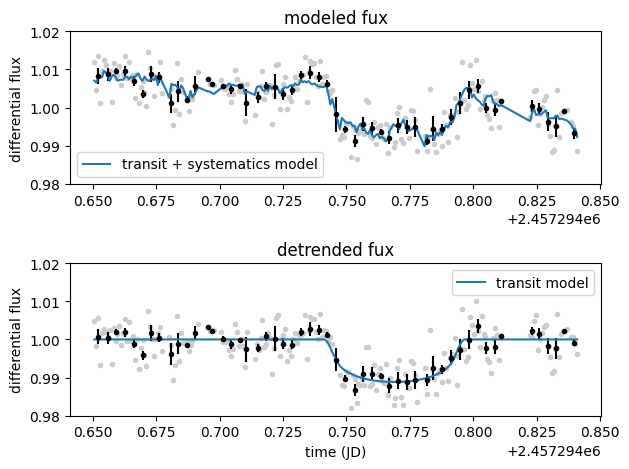

In [20]:
modeled_lc = light_curve_model(time, opt)

ax1 = plt.subplot(211, ylabel="differential flux", title="modeled fux")
data.plot()
data.bin(5 / 60 / 24, estimate_error=True).errorbar()
ax1.plot(data.time, modeled_lc, label="transit + systematics model")
ax1.set_ylim(0.98, 1.02)
plt.legend()

detrended_flux = data.copy()
detrended_flux.fluxes = detrended_flux.fluxes - opt["w"] @ X + 1.0
modeled_transit = transit_model(time, opt)

ax2 = plt.subplot(
    212, xlabel="time (JD)", ylabel="differential flux", title="detrended fux"
)
detrended_flux.plot()
detrended_flux.bin(5 / 60 / 24, estimate_error=True).errorbar()
plt.plot(time, modeled_transit + 1.0, label="transit model")
ax2.set_ylim(0.98, 1.02)
plt.legend()

plt.tight_layout()

## Bayesian modeling and MCMC

In [9]:
def model():
    # Prior distributions
    period = 10.0
    t0 = sample("t0", distributions.Uniform(time.min(), time.max()))
    duration = sample("duration", distributions.Uniform(0.01, 0.1))
    r = sample("r", distributions.Uniform(0.01, 0.2))
    b = sample("b", distributions.Uniform(-1e-5, 1.0 + prior["r"]))
    w = sample("w", distributions.Normal(jnp.zeros(X.shape[0]), 2.0))

    # The orbit and light curve
    y_pred = light_curve_model(
        time, {"t0": t0, "duration": duration, "b": b, "r": r, "period": period, "w": w}
    )

    # Let's track the light curve
    deterministic("light_curve", y_pred)

    # The likelihood function assuming Gaussian uncertainty
    sample("obs", distributions.Normal(y_pred, data.error), obs=flux)

In [10]:
from numpyro import infer

sampler = infer.MCMC(
    infer.NUTS(
        model,
        dense_mass=True,
        regularize_mass_matrix=False,
        init_strategy=infer.init_to_value(values=opt),
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1))

sample: 100%|██████████| 3000/3000 [00:18<00:00, 165.10it/s, 7 steps of size 4.25e-01. acc. prob=0.70] 


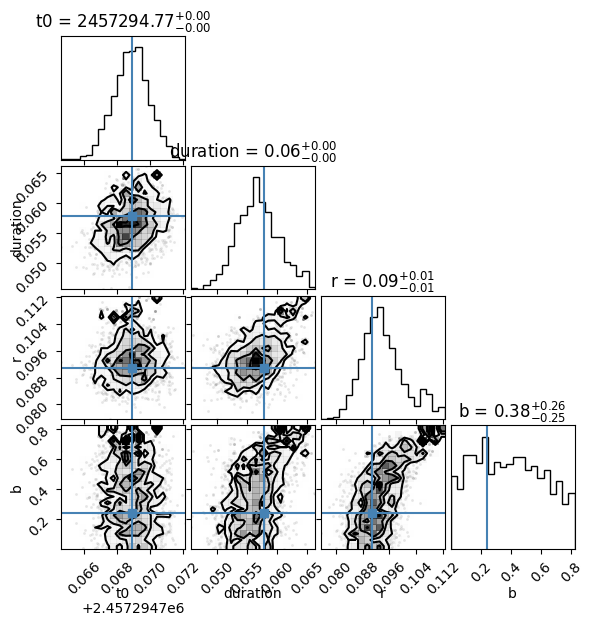

In [11]:
import corner
import arviz as az

gillon2016 = [opt["t0"], 83.3 / 60 / 24, np.sqrt(0.826e-2), 0.24]

inf_data = az.from_numpyro(sampler)

fig = plt.figure(figsize=(6, 6))
_ = corner.corner(
    inf_data,
    var_names=["t0", "duration", "r", "b"],
    truths=gillon2016,
    show_titles=True,
    fig=fig,
)